# This is our Training code InceptionV methods. Please note we cannot uploade the huge dataset in submission so reading the files is not possible here. We can show demo in our system if needed. Also, this training takes a lot of time on PCs, and needs GPUs for training

In [ ]:
# import os
# import numpy as np
# import pandas as pd
# import tensorflow as tf
# import matplotlib.pyplot as plt
# from sklearn.utils import shuffle
# from sklearn.model_selection import train_test_split

In [ ]:
import xml.etree.ElementTree as ET
import requests
import os
import concurrent.futures

# dfonwloading the data from the urls
def fetch_xml(xml_url):
    response = requests.get(xml_url)
    if response.status_code != 200:
        return None
    return response.content


# finding the ursls in the xml file present on the google cloud container

def parse_xml(xml_content):
    root = ET.fromstring(xml_content)
    namespace = {'s3': 'http://doc.s3.amazonaws.com/2006-03-01'}
    base_url = "https://storage.googleapis.com/quickdraw_dataset/"

    file_urls = []
    for content in root.findall(".//s3:Contents", namespace):
        key = content.find("s3:Key", namespace).text
        if key.startswith("full/numpy_bitmap/") and key.endswith(".npy"):
            file_urls.append(base_url + key)
    return file_urls

def download_file(file_url, download_folder):
    file_path = os.path.join(download_folder, os.path.basename(file_url))
    if os.path.exists(file_path):
        return

    response = requests.get(file_url)
    if response.status_code == 200:
        with open(file_path, "wb") as f:
            f.write(response.content)

def download_npy_files(xml_url, download_folder):
    if not os.path.exists(download_folder):
        os.makedirs(download_folder)

    xml_content = fetch_xml(xml_url)
    if xml_content is None:
        return

    file_urls = parse_xml(xml_content)
    with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
        executor.map(lambda url: download_file(url, download_folder), file_urls)

# if __name__ == "__main__":
xml_url = "https://storage.googleapis.com/quickdraw_dataset/"
download_folder = "data"
download_npy_files(xml_url, download_folder)

In [ ]:
# xml_url = "https://storage.googleapis.com/quickdraw_dataset/"
# download_folder = "data"
# download_npy_files(xml_url, download_folder)

In [23]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [ ]:
# import numpy as np

# def normalize(data):
#     data = data.astype(np.float32)    
#     normalized = (data - 0) / (255 - 0)    
#     scaled = normalized * 2 - 1
    
#     return scaled


In [ ]:
#incterpolaetion to -1 , 1
def normalize(data):
  return np.interp(data, [0,255], [-1,1])

In [ ]:
def shuffle_data(X, y):
  return shuffle(X, y, random_state=42)

In [ ]:
def load_data(files, N):
    data_list = []
    labels_list = []

    for i, item in enumerate(files):
        arr = np.load(f'data/{item}', mmap_mode='r')[:N]
        # N = arr.shape[0]
        arr = arr.reshape(N, 28, 28, 1)
        data_list.append(arr)
        labels_list.append(np.full(N, i, dtype=np.int32))
        del (arr)
        # del (N)

    data = np.concatenate(data_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    return data, labels


In [ ]:
# constants
N = 50000  #No of examples from each classs
files = os.listdir('data')
classes = len(files)

In [9]:
X, y = load_data(files, N)

In [ ]:
X.shape, y.shape

In [11]:
X, y = shuffle(X, y)

In [12]:
X = normalize(X)

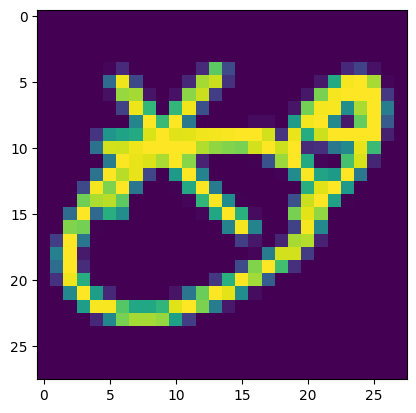

In [13]:
plt.imshow(X[458])

In [14]:
files[y[458]]

'helicopter.npy'

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Input, Resizing, Conv2D
from tensorflow.keras.models import Model

def build_model(classes=345):
    with tf.device('/GPU:0'):
        input_layer = Input(shape=(28, 28, 1))

        # Converting 1-channel to 3-channel, inception needs 3 channels (75*75)
        x = Conv2D(3, (1, 1), activation='relu', padding='same')(input_layer)
        x = Resizing(75, 75)(x)

        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
        base_model.trainable = False
        x = base_model(x)

        x = Flatten()(x)
        # x = Dense(256, activation='relu')(x)
        x = Dense(128, activation='relu')(x)
        # x = BatchNormalization()(x)

        x = Dense(64, activation='relu')(x)
        # x = BatchNormalization()(x)
        
        x = Dense(32, activation='relu')(x)
        x = BatchNormalization()(x)
        
        x = Dropout(0.3)(x)
        # x = Dropout(0.1)(x)
        x = Dense(classes, activation='softmax')(x)  # Output layer
        
        
        model = Model(inputs=input_layer, outputs=x)

    return model

model = build_model(classes=classes)
model.summary()


I0000 00:00:1744666684.295972     697 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744666684.296715     697 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 3)           │               6 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing (Resizing)                  │ (None, 75, 75, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 1, 1, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_94               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 50)                  │           1,650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,077,176 (84.22 MB)

 Trainable params: 274,328 (1.05 MB)

 Non-trainable params: 21,802,848 (83.17 MB)

In [18]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [25]:
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
# model.fit(X_train, y_train, epochs=1000, batch_size=1000, validation_split=0.2, callbacks=[early_stopping])
model.fit(X_train, y_train, epochs=10, batch_size=1024, validation_split=0.2)

Epoch 1/10


I0000 00:00:1744658075.876811      94 service.cc:148] XLA service 0x7daba40349f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744658075.877622      94 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1744658075.877643      94 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1744658077.782744      94 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-14 19:14:52.158718: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng50{} for conv (f32[1024,192,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[1024,320,1,1]{3,2,1,0}, f32[320,192,3,3]{3,2,1,0}), window={size=3x3 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_que

743/743 ━━━━━━━━━━━━━━━━━━━━ 408s 486ms/step - accuracy: 0.4099 - loss: 2.4347 - val_accuracy: 0.6496 - val_loss: 1.3194
Epoch 2/10
743/743 ━━━━━━━━━━━━━━━━━━━━ 330s 445ms/step - accuracy: 0.6304 - loss: 1.4259 - val_accuracy: 0.6761 - val_loss: 1.2138
Epoch 3/10
743/743 ━━━━━━━━━━━━━━━━━━━━ 330s 445ms/step - accuracy: 0.6632 - loss: 1.3012 - val_accuracy: 0.6879 - val_loss: 1.1590
Epoch 4/10
743/743 ━━━━━━━━━━━━━━━━━━━━ 331s 445ms/step - accuracy: 0.6805 - loss: 1.2368 - val_accuracy: 0.6985 - val_loss: 1.1220
Epoch 5/10
743/743 ━━━━━━━━━━━━━━━━━━━━ 331s 445ms/step - accuracy: 0.6905 - loss: 1.1972 - val_accuracy: 0.7025 - val_loss: 1.1090
Epoch 6/10
743/743 ━━━━━━━━━━━━━━━━━━━━ 331s 445ms/step - accuracy: 0.6980 - loss: 1.1677 - val_accuracy: 0.7070 - val_loss: 1.0950
Epoch 7/10
743/743 ━━━━━━━━━━━━━━━━━━━━ 331s 445ms/step - accuracy: 0.7035 - loss: 1.1442 - val_accuracy: 0.7090 - val_loss: 1.0901
Epoch 8/10
743/743 ━━━━━━━━━━━━━━━━━━━━ 331s 445ms/step - accuracy: 0.7087 - loss: 1.12

In [26]:
model.save('model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
original: cow.npy, predicted: cow.npy


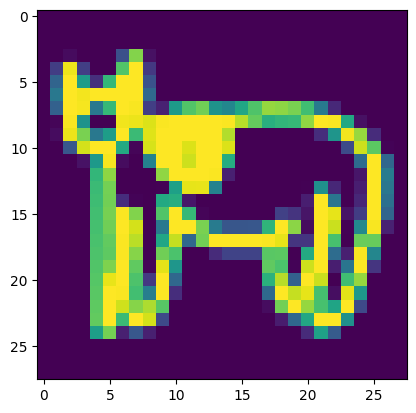

In [36]:
i = 7441

plt.imshow(X_test[i])

print(f"original: {files[y_test[i]]}, predicted: {files[model.predict(X_test[i: i+1]).argmax(axis=1)[0]]}")

In [31]:
y_prob = model.predict(X_test)
y_pred = y_prob.argmax(axis=1)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step


In [32]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.7154

In [ ]:
model.base_model.layers

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import gc


# function for un freeezing particular layers of the model
def apply_partial_freezing(base_model, unfreeze_from):
    base_model.trainable = True
    set_trainable = False
    for layer in base_model.layers:
        if unfreeze_from in layer.name:
            set_trainable = True
        layer.trainable = set_trainable

#Same as above also added partial unfreezing of layers
# for fine tuning
def build_model(classes=345, unfreeze_from='mixed10'):
    input_layer = tf.keras.Input(shape=(28, 28, 1))

    x = tf.keras.layers.Conv2D(3, (1, 1), activation='relu', padding='same')(input_layer)
    x = tf.keras.layers.Resizing(75, 75)(x)

    base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
    
    if unfreeze_from == 'none':
        base_model.trainable = False
    else:
        apply_partial_freezing(base_model, unfreeze_from)

    x = base_model(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    output = tf.keras.layers.Dense(classes, activation='softmax')(x)
    
    return tf.keras.Model(inputs=input_layer, outputs=output)

In [ ]:
def train_and_plot_each_model(X_train, y_train, epochs=3):
    unfreeze_blocks = ['none', 'mixed10', 'mixed9', 'mixed8', 'mixed7', 'mixed6']

    for block in unfreeze_blocks:
        print(f"Training model with unfreeze_from = {block}")
        
        
        model = build_model(classes=345, unfreeze_from=block)
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        history = model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=1024,
            validation_split=0.2,
            verbose=2
        )

        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['val_accuracy'], label='val_accuracy')
        plt.title(f'Val Accuracy - {block}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(history.history['val_loss'], label='val_loss', color='orange')
        plt.title(f'Val Loss - {block}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)

        plt.suptitle(f"Ablation: {block}")
        plt.tight_layout()
        plt.show()



        # clearing the memory (RAM)
        # to prevent out of memory error
        del model
        del history
        tf.keras.backend.clear_session()
        gc.collect()



 Training model with unfreeze_from = none
Epoch 1/3


I0000 00:00:1744666725.025745     734 service.cc:148] XLA service 0x7f8dc4043b60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744666725.026639     734 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1744666725.026662     734 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1744666727.024930     734 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-14 21:39:01.232979: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng50{} for conv (f32[1024,192,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[1024,320,1,1]{3,2,1,0}, f32[320,192,3,3]{3,2,1,0}), window={size=3x3 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_que

743/743 - 407s - 547ms/step - accuracy: 0.5447 - loss: 2.1007 - val_accuracy: 0.6638 - val_loss: 1.2658
Epoch 2/3
743/743 - 330s - 444ms/step - accuracy: 0.6600 - loss: 1.3159 - val_accuracy: 0.6892 - val_loss: 1.1593
Epoch 3/3
743/743 - 330s - 444ms/step - accuracy: 0.6847 - loss: 1.2167 - val_accuracy: 0.7035 - val_loss: 1.1046


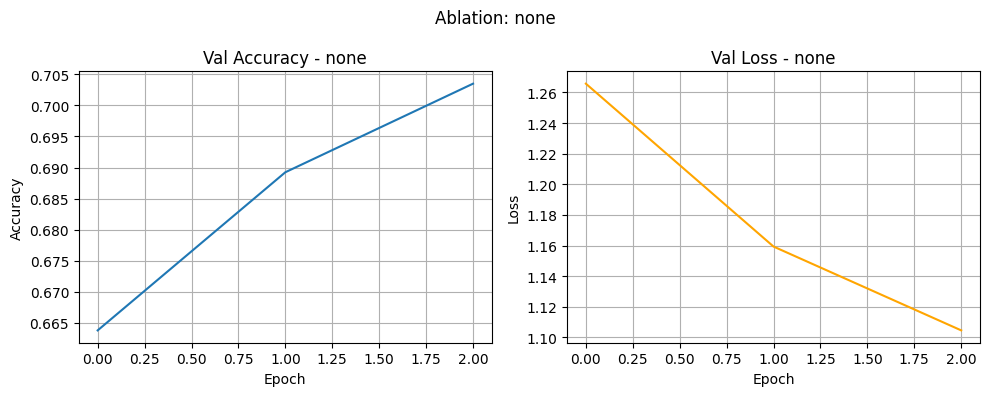


 Training model with unfreeze_from = mixed10
Epoch 1/3
743/743 - 368s - 496ms/step - accuracy: 0.5489 - loss: 2.0884 - val_accuracy: 0.6640 - val_loss: 1.2634
Epoch 2/3
743/743 - 330s - 444ms/step - accuracy: 0.6564 - loss: 1.3249 - val_accuracy: 0.6875 - val_loss: 1.1670
Epoch 3/3
743/743 - 331s - 445ms/step - accuracy: 0.6796 - loss: 1.2321 - val_accuracy: 0.6954 - val_loss: 1.1319


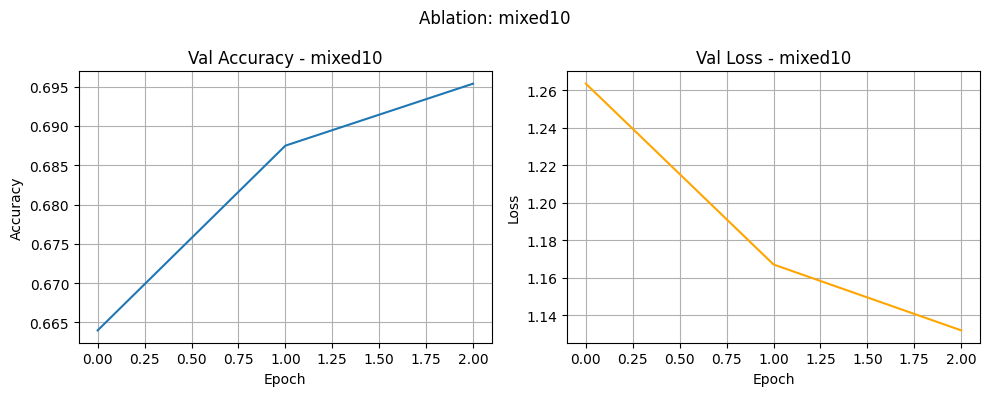


 Training model with unfreeze_from = mixed9
Epoch 1/3
743/743 - 386s - 519ms/step - accuracy: 0.6893 - loss: 1.6076 - val_accuracy: 0.7441 - val_loss: 1.0019
Epoch 2/3
743/743 - 337s - 453ms/step - accuracy: 0.7743 - loss: 0.8994 - val_accuracy: 0.7736 - val_loss: 0.8534
Epoch 3/3
743/743 - 336s - 452ms/step - accuracy: 0.7966 - loss: 0.7955 - val_accuracy: 0.7792 - val_loss: 0.8304


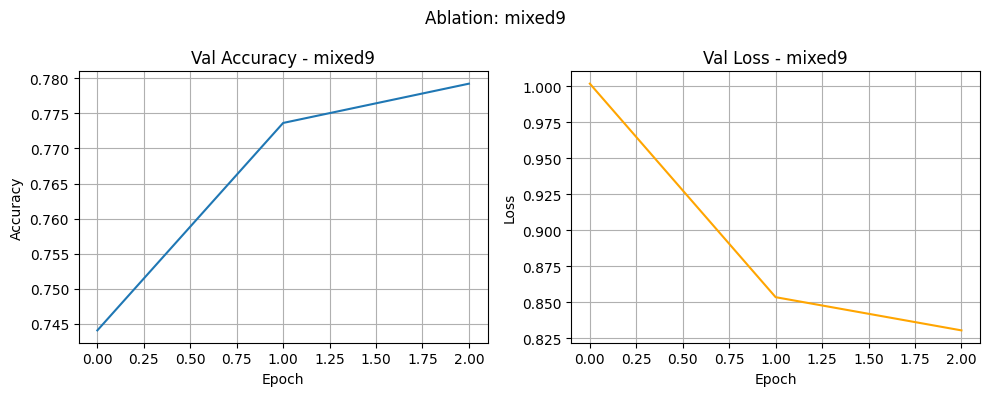


 Training model with unfreeze_from = mixed8
Epoch 1/3
743/743 - 397s - 535ms/step - accuracy: 0.7408 - loss: 1.4509 - val_accuracy: 0.7871 - val_loss: 0.8499
Epoch 2/3
743/743 - 341s - 459ms/step - accuracy: 0.8143 - loss: 0.7579 - val_accuracy: 0.8090 - val_loss: 0.7230
Epoch 3/3
743/743 - 341s - 458ms/step - accuracy: 0.8314 - loss: 0.6724 - val_accuracy: 0.8145 - val_loss: 0.7136


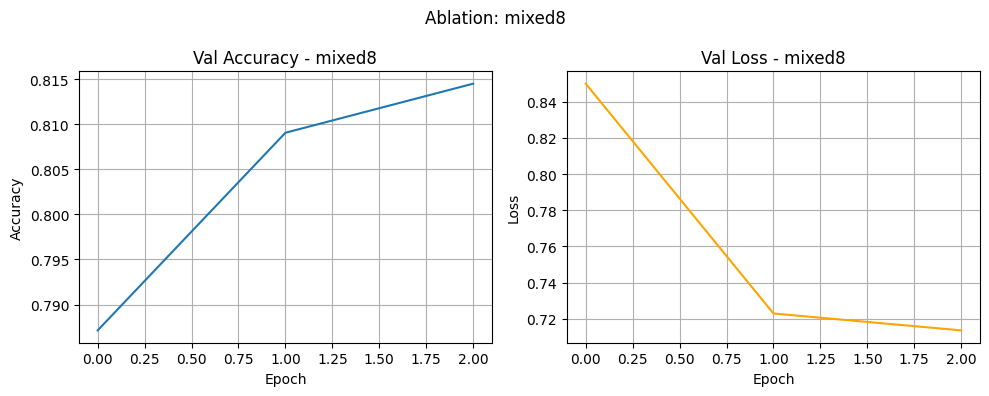


 Training model with unfreeze_from = mixed7
Epoch 1/3
743/743 - 408s - 549ms/step - accuracy: 0.7791 - loss: 1.2951 - val_accuracy: 0.8259 - val_loss: 0.6988
Epoch 2/3
743/743 - 346s - 466ms/step - accuracy: 0.8481 - loss: 0.6277 - val_accuracy: 0.8452 - val_loss: 0.6045
Epoch 3/3
743/743 - 346s - 466ms/step - accuracy: 0.8646 - loss: 0.5439 - val_accuracy: 0.8503 - val_loss: 0.5882


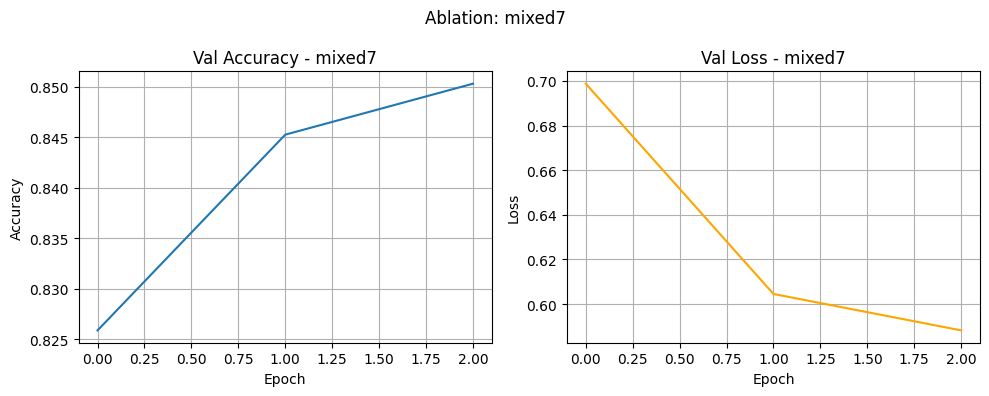


 Training model with unfreeze_from = mixed6
Epoch 1/3
743/743 - 429s - 577ms/step - accuracy: 0.7757 - loss: 1.3317 - val_accuracy: 0.8328 - val_loss: 0.6642
Epoch 2/3
743/743 - 360s - 485ms/step - accuracy: 0.8521 - loss: 0.6123 - val_accuracy: 0.8539 - val_loss: 0.5743
Epoch 3/3
743/743 - 360s - 485ms/step - accuracy: 0.8678 - loss: 0.5325 - val_accuracy: 0.8606 - val_loss: 0.5487


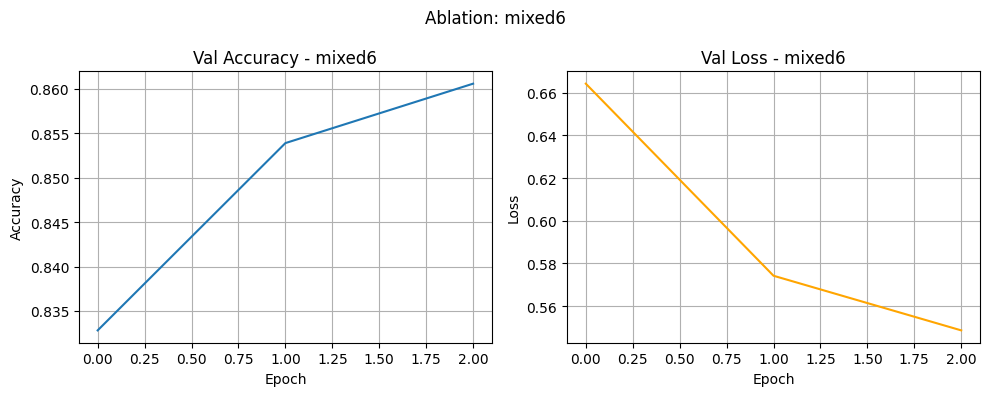

In [21]:
train_and_plot_each_model(X_train, y_train, epochs=3)
